<a href="https://colab.research.google.com/github/iodapro/codes/blob/master/RealEstate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import xgboost
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
import sklearn.ensemble as se
from scipy.stats import ks_2samp
import re
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import glorot_normal

from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold, KFold, StratifiedKFold
from sklearn.svm import SVR
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from keras.regularizers import l1, l2
from collections import OrderedDict
import os
import pickle
from sys import platform
from os import listdir
from os.path import isfile, join
from keras.models import load_model
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
def getSeparator():
    separator = ''
    if platform == "linux" or platform == "linux2":
        separator = '/'
    elif platform == "darwin":
        separator = '/'
    elif platform == "win32":
        separator = '\\'
    return separator

def preparePlaceForModels(ml_algo):
    path = ml_algo
    if os.path.isdir(ml_algo) == True:
        filelist = [ f for f in os.listdir(ml_algo) if f.endswith(".sav") ]
        for f in filelist:
            os.remove(os.path.join(ml_algo, f))
        os.rmdir(path)
    os.mkdir(path)

def chooseMLModel(ml_algo):
        if ml_algo == 'linear':
            model = LinearRegression()
        elif ml_algo == 'lasso':
            model = Lasso(alpha = 0.001)
        elif ml_algo == 'ridge':
            model = Ridge(0.001)
        elif ml_algo == 'xgb':
            model = xgboost.XGBRegressor(n_estimators = 500, objective='reg:squarederror')
        elif ml_algo == 'gradB':
            params = {'n_estimators': 500, 'max_depth': 10, 'min_samples_split': 2, 'learning_rate': 0.01, 'loss': 'ls'}
            model = se.GradientBoostingRegressor(**params)
        elif ml_algo == 'rf':
            model = se.RandomForestRegressor(n_estimators = 500)
        elif ml_algo == 'dt':
            model = DecisionTreeRegressor()
        elif ml_algo == 'svr':
            model = SVR('rbf', gamma = 'scale')
        elif ml_algo == 'knn_uniform':
            n_neighbors = 15
            model = neighbors.KNeighborsRegressor(n_neighbors, weights='uniform')
        elif ml_algo == 'knn_distance':    
            n_neighbors = 15
            model = neighbors.KNeighborsRegressor(n_neighbors, weights='distance')
        else:
            model = []
        return model

def getNNResults(ml_algo, X, Y):
    separator = getSeparator()
    
    kfold = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 1)
    r2_score_average = 0.
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    counter = 0
    
    preparePlaceForModels(ml_algo)
    
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        initializer = glorot_normal()
        es = keras.callbacks.EarlyStopping(monitor='val_loss',patience=100, verbose=1)
        model = Sequential()
        model.add(Dense(X.shape[1], input_dim=X.shape[1], activation='relu'))
        model.add(Dense(5, activation='relu',kernel_initializer=initializer, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.add(Dense(1 ,kernel_initializer=initializer,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        model.compile(loss='mse', optimizer='adam', metrics=['mse'])
        history = model.fit(X_train, y_train, epochs=2000, batch_size=32,validation_data=(X_test, y_test), callbacks = [es], verbose = 0)
        model.save(ml_algo+separator+ml_algo+str(counter)+'.sav')

        y_predict = model.predict(X_test)
        y_predict = np.reshape(y_predict, (y_predict.shape[0],))
        _, pValueLinear = ks_2samp(y_test,y_predict)
        
        r2_scores.append(r2_score(y_test,y_predict))
        rmse_scores.append(mean_absolute_error(y_test,y_predict))
        mae_scores.append(np.sqrt(mean_squared_error(y_test,y_predict)))
        
        r2_score_average += r2_score(y_test,y_predict)
        counter += 1
        print('%s algorithm: P-value of KS test: %f and r2 score: %f' % (ml_algo, pValueLinear, r2_score(y_test,y_predict)))
    print('R2 score is %f' % (r2_score_average / counter))
    
    return r2_scores, rmse_scores, mae_scores

def getMLResults(ml_algo, X, Y):    
    separator = getSeparator()
    
    kfold = RepeatedKFold(n_splits = 10, n_repeats = 1, random_state = 1)
    r2_score_average = 0.
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    counter = 0
    
    preparePlaceForModels(ml_algo)
    #print(X)
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model = chooseMLModel(ml_algo)
        
        model.fit(X_train, y_train)
        pickle.dump(model, open(ml_algo+separator+ml_algo+str(counter)+'.sav', 'wb'))
        y_predict = model.predict(X_test)
        y_predict = np.reshape(y_predict, (y_predict.shape[0],))
        _, pValueLinear = ks_2samp(y_test,y_predict)
        
        r2_scores.append(r2_score(y_test,y_predict))
        rmse_scores.append(mean_absolute_error(y_test,y_predict))
        mae_scores.append(np.sqrt(mean_squared_error(y_test,y_predict)))
        
        r2_score_average += r2_score(y_test,y_predict)
        counter += 1
        print('%s algorithm: P-value of KS test: %f and r2 score: %f' % (ml_algo, pValueLinear, r2_score(y_test,y_predict)))
    print('R2 score is %f' % (r2_score_average / counter))
    
    return r2_scores, rmse_scores, mae_scores

def fit(ml_algo, X, Y):
    if ml_algo == 'nn':
        return getNNResults(ml_algo, X, Y)
    else:
        return getMLResults(ml_algo, X, Y)

def numericalSort(value):
        numbers = re.compile(r'(\d+)')
        parts = numbers.split(value)
        parts[1::2] = map(int, parts[1::2])
        return parts

def choseImportant(X_train, y_train):
    model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 objective='reg:squarederror',
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

    model.fit(X_train, y_train)

    features = OrderedDict(sorted(model._Booster.get_fscore().items(), key=lambda t: t[1], reverse=True))
    
    most_relevant_features= list( dict((k, v) for k, v in model._Booster.get_fscore().items() if v >= 15).keys())
    
    return most_relevant_features

def predictMLResults(X, pathToModel):
    #print(onlyfiles)
    onlyfiles = [f for f in listdir(pathToModel) if isfile(join(pathToModel, f))]
    #onlyfiles = sorted(glob.glob(onlyfiles), key=numericalSort)[1:]
    y_global = []
    for el in onlyfiles:
        model = pickle.load(open(pathToModel+getSeparator()+el, 'rb'))
        y_pred = model.predict(X)
        y_global.append(y_pred)        
    return np.asarray(y_global)

def predictNNResults(X, pathToModel):
    onlyfiles = [f for f in listdir(pathToModel) if isfile(join(pathToModel, f))]
    #onlyfiles = sorted(glob.glob(onlyfiles), key=numericalSort)[1:]
    y_global = []
    for el in onlyfiles:
        model = load_model(pathToModel+getSeparator()+el)
        y_pred = model.predict(X)[:,0]
        y_global.append(y_pred)
        
    return np.asarray(y_global)

def predictResult(X, pathToModel):
    if pathToModel == 'nn':
        return predictNNResults(X, pathToModel)
    else:
        return predictMLResults(X, pathToModel)
    
def score(ml_algo, X_test, y_test):
    r2_scores = []
    rmse_scores = []
    mae_scores = []
    r2_score_average = 0.
    counter = 0
    y_predict = predictResult(X_test, ml_algo)
    for el in y_predict:
        r2_scores.append(r2_score(y_test,el))
        rmse_scores.append(mean_absolute_error(y_test,el))
        mae_scores.append(np.sqrt(mean_squared_error(y_test,el)))
        _, pValueLinear = ks_2samp(y_test,el)
        r2_score_average += r2_score(y_test,el)
        counter += 1
        print('%s algorithm: P-value of KS test: %f and r2 score: %f' % (ml_algo, pValueLinear, r2_score(y_test,el)))
    print('R2 score is %f' % (r2_score_average / counter))
    return r2_scores, rmse_scores, mae_scores

In [0]:
# r2, rmse, cross validation score, mae
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.initializers import glorot_normal
from sklearn.metrics import r2_score

In [0]:
df = pd.read_csv('kisat_processed_replaced_onehot.csv')

In [0]:
def normalize(featureNames):
    scalers = {}
    for featureName in featureNames:
        scaler = StandardScaler()
        df[featureName] = scaler.fit_transform(df[featureName].values.reshape(-1,1))
        scalers[featureName] = scaler
    df.drop(df.columns[df.columns.str.contains('Unnamed',case = False)],axis = 1, inplace = True)
    return df, scalers

def plot(dictionary):
    plt.figure()
    for el in dictionary.items():
        plt.plot(el[1], '-o', label = el[0])
    plt.legend()
    plt.show()

In [0]:
df, scalers = normalize(['m2net', 'm2burut', 'odasayisi', 'binayasi', 'new_bulundugukat', 'katsayisi', 'isitma', 'fiyat'])

X = df.drop('fiyat', axis = 1)
Y = df['fiyat']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [0]:
most_relevant_features = choseImportant(X_train, y_train)

X = df[most_relevant_features].values
Y = df['fiyat'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [66]:
r2_scores_svr, rmse_scores_svr, mae_scores_svr = fit('svr', X_train,y_train)


svr algorithm: P-value of KS test: 0.777231 and r2 score: 0.737802
svr algorithm: P-value of KS test: 0.476207 and r2 score: 0.735854
svr algorithm: P-value of KS test: 0.370694 and r2 score: 0.786360
svr algorithm: P-value of KS test: 0.534104 and r2 score: 0.771577
svr algorithm: P-value of KS test: 0.421563 and r2 score: 0.708008
svr algorithm: P-value of KS test: 0.592723 and r2 score: 0.765841
svr algorithm: P-value of KS test: 0.654462 and r2 score: 0.729928
svr algorithm: P-value of KS test: 0.474464 and r2 score: 0.767863
svr algorithm: P-value of KS test: 0.716100 and r2 score: 0.788633
svr algorithm: P-value of KS test: 0.654462 and r2 score: 0.768173
R2 score is 0.756004


In [67]:
r2_scores_knn_uniform, rmse_scores_knn_uniform, mae_scores_knn_uniform = fit('knn_uniform', X_train,y_train)


knn_uniform algorithm: P-value of KS test: 0.656127 and r2 score: 0.708828
knn_uniform algorithm: P-value of KS test: 0.370694 and r2 score: 0.725663
knn_uniform algorithm: P-value of KS test: 0.323898 and r2 score: 0.769741
knn_uniform algorithm: P-value of KS test: 0.323898 and r2 score: 0.755729
knn_uniform algorithm: P-value of KS test: 0.656127 and r2 score: 0.723644
knn_uniform algorithm: P-value of KS test: 0.279821 and r2 score: 0.740635
knn_uniform algorithm: P-value of KS test: 0.241485 and r2 score: 0.714524
knn_uniform algorithm: P-value of KS test: 0.040737 and r2 score: 0.716306
knn_uniform algorithm: P-value of KS test: 0.322336 and r2 score: 0.755554
knn_uniform algorithm: P-value of KS test: 0.474464 and r2 score: 0.723413
R2 score is 0.733404


In [68]:
r2_scores_knn_distance, rmse_scores_knn_distance, mae_scores_knn_distance = fit('knn_distance', X_train,y_train)


knn_distance algorithm: P-value of KS test: 0.955249 and r2 score: 0.715886
knn_distance algorithm: P-value of KS test: 0.421563 and r2 score: 0.734776
knn_distance algorithm: P-value of KS test: 0.656127 and r2 score: 0.778486
knn_distance algorithm: P-value of KS test: 0.594452 and r2 score: 0.760310
knn_distance algorithm: P-value of KS test: 0.832786 and r2 score: 0.718997
knn_distance algorithm: P-value of KS test: 0.241485 and r2 score: 0.743072
knn_distance algorithm: P-value of KS test: 0.176794 and r2 score: 0.713270
knn_distance algorithm: P-value of KS test: 0.040737 and r2 score: 0.724032
knn_distance algorithm: P-value of KS test: 0.592723 and r2 score: 0.759339
knn_distance algorithm: P-value of KS test: 0.775828 and r2 score: 0.735695
R2 score is 0.738386


In [69]:
r2_scores_linear, rmse_scores_linear, mae_scores_linear = fit('linear', X_train,y_train)


linear algorithm: P-value of KS test: 0.717656 and r2 score: 0.679750
linear algorithm: P-value of KS test: 0.127520 and r2 score: 0.700891
linear algorithm: P-value of KS test: 0.594452 and r2 score: 0.723028
linear algorithm: P-value of KS test: 0.323898 and r2 score: 0.744848
linear algorithm: P-value of KS test: 0.476207 and r2 score: 0.742690
linear algorithm: P-value of KS test: 0.176794 and r2 score: 0.715235
linear algorithm: P-value of KS test: 0.419858 and r2 score: 0.684491
linear algorithm: P-value of KS test: 0.008471 and r2 score: 0.674550
linear algorithm: P-value of KS test: 0.532350 and r2 score: 0.740839
linear algorithm: P-value of KS test: 0.279821 and r2 score: 0.718678
R2 score is 0.712500


In [70]:
r2_scores_lasso, rmse_scores_lasso, mae_scores_lasso = fit('lasso', X_train,y_train)


lasso algorithm: P-value of KS test: 0.717656 and r2 score: 0.680824
lasso algorithm: P-value of KS test: 0.089402 and r2 score: 0.701618
lasso algorithm: P-value of KS test: 0.594452 and r2 score: 0.722791
lasso algorithm: P-value of KS test: 0.281291 and r2 score: 0.744251
lasso algorithm: P-value of KS test: 0.421563 and r2 score: 0.741739
lasso algorithm: P-value of KS test: 0.176794 and r2 score: 0.715243
lasso algorithm: P-value of KS test: 0.419858 and r2 score: 0.685649
lasso algorithm: P-value of KS test: 0.010776 and r2 score: 0.672406
lasso algorithm: P-value of KS test: 0.532350 and r2 score: 0.741397
lasso algorithm: P-value of KS test: 0.322336 and r2 score: 0.718129
R2 score is 0.712405


In [71]:
r2_scores_ridge, rmse_scores_ridge, mae_scores_ridge = fit('ridge', X_train,y_train)


ridge algorithm: P-value of KS test: 0.717656 and r2 score: 0.679750
ridge algorithm: P-value of KS test: 0.127520 and r2 score: 0.700891
ridge algorithm: P-value of KS test: 0.594452 and r2 score: 0.723028
ridge algorithm: P-value of KS test: 0.323898 and r2 score: 0.744848
ridge algorithm: P-value of KS test: 0.476207 and r2 score: 0.742690
ridge algorithm: P-value of KS test: 0.176794 and r2 score: 0.715235
ridge algorithm: P-value of KS test: 0.419858 and r2 score: 0.684491
ridge algorithm: P-value of KS test: 0.008471 and r2 score: 0.674549
ridge algorithm: P-value of KS test: 0.532350 and r2 score: 0.740839
ridge algorithm: P-value of KS test: 0.279821 and r2 score: 0.718678
R2 score is 0.712500


In [72]:
r2_scores_xgb, rmse_scores_xgb, mae_scores_xgb = fit('xgb', X_train,y_train)


xgb algorithm: P-value of KS test: 0.777231 and r2 score: 0.737316
xgb algorithm: P-value of KS test: 0.534104 and r2 score: 0.763789
xgb algorithm: P-value of KS test: 0.882170 and r2 score: 0.790844
xgb algorithm: P-value of KS test: 0.594452 and r2 score: 0.822910
xgb algorithm: P-value of KS test: 0.882170 and r2 score: 0.778476
xgb algorithm: P-value of KS test: 0.716100 and r2 score: 0.790800
xgb algorithm: P-value of KS test: 0.106222 and r2 score: 0.740048
xgb algorithm: P-value of KS test: 0.026727 and r2 score: 0.771673
xgb algorithm: P-value of KS test: 0.775828 and r2 score: 0.806431
xgb algorithm: P-value of KS test: 0.775828 and r2 score: 0.767364
R2 score is 0.776965


In [48]:
r2_scores_gradB, rmse_scores_gradB, mae_scores_gradB = fit('gradB', X_train,y_train)

gradB algorithm: P-value of KS test: 0.777231 and r2 score: 0.705936
gradB algorithm: P-value of KS test: 0.323898 and r2 score: 0.718417
gradB algorithm: P-value of KS test: 0.717656 and r2 score: 0.767180
gradB algorithm: P-value of KS test: 0.421563 and r2 score: 0.804223
gradB algorithm: P-value of KS test: 0.717656 and r2 score: 0.766268
gradB algorithm: P-value of KS test: 0.532350 and r2 score: 0.779706
gradB algorithm: P-value of KS test: 0.150006 and r2 score: 0.728973
gradB algorithm: P-value of KS test: 0.021473 and r2 score: 0.733385
gradB algorithm: P-value of KS test: 0.881187 and r2 score: 0.785678
gradB algorithm: P-value of KS test: 0.831577 and r2 score: 0.708360
R2 score is 0.749813


In [49]:
r2_scores_rf, rmse_scores_rf, mae_scores_rf = fit('rf', X_train,y_train)

rf algorithm: P-value of KS test: 0.923439 and r2 score: 0.730978
rf algorithm: P-value of KS test: 0.281291 and r2 score: 0.742753
rf algorithm: P-value of KS test: 0.882170 and r2 score: 0.787635
rf algorithm: P-value of KS test: 0.323898 and r2 score: 0.814649
rf algorithm: P-value of KS test: 0.656127 and r2 score: 0.752142
rf algorithm: P-value of KS test: 0.279821 and r2 score: 0.789573
rf algorithm: P-value of KS test: 0.126577 and r2 score: 0.741385
rf algorithm: P-value of KS test: 0.033087 and r2 score: 0.723507
rf algorithm: P-value of KS test: 0.716100 and r2 score: 0.791553
rf algorithm: P-value of KS test: 0.881187 and r2 score: 0.738767
R2 score is 0.761294


In [50]:
r2_scores_dt, rmse_scores_dt, mae_scores_dt = fit('dt', X_train,y_train)

dt algorithm: P-value of KS test: 0.421563 and r2 score: 0.525690
dt algorithm: P-value of KS test: 0.656127 and r2 score: 0.433721
dt algorithm: P-value of KS test: 0.990458 and r2 score: 0.620124
dt algorithm: P-value of KS test: 0.656127 and r2 score: 0.673778
dt algorithm: P-value of KS test: 0.955249 and r2 score: 0.626412
dt algorithm: P-value of KS test: 0.775828 and r2 score: 0.659979
dt algorithm: P-value of KS test: 0.279821 and r2 score: 0.604973
dt algorithm: P-value of KS test: 0.207207 and r2 score: 0.540644
dt algorithm: P-value of KS test: 0.976967 and r2 score: 0.650797
dt algorithm: P-value of KS test: 0.592723 and r2 score: 0.519089
R2 score is 0.585521


In [51]:
r2_scores_nn, rmse_scores_nn, mae_scores_nn = fit('nn', X_train,y_train)

Epoch 00342: early stopping
nn algorithm: P-value of KS test: 0.208470 and r2 score: 0.749656
Epoch 00536: early stopping
nn algorithm: P-value of KS test: 0.594452 and r2 score: 0.738556
Epoch 00638: early stopping
nn algorithm: P-value of KS test: 0.323898 and r2 score: 0.797409
Epoch 00933: early stopping
nn algorithm: P-value of KS test: 0.777231 and r2 score: 0.793563
Epoch 00685: early stopping
nn algorithm: P-value of KS test: 0.832786 and r2 score: 0.797508
Epoch 00906: early stopping
nn algorithm: P-value of KS test: 0.207207 and r2 score: 0.773122
Epoch 00500: early stopping
nn algorithm: P-value of KS test: 0.126577 and r2 score: 0.710488
Epoch 01109: early stopping
nn algorithm: P-value of KS test: 0.073591 and r2 score: 0.767822
Epoch 00582: early stopping
nn algorithm: P-value of KS test: 0.592723 and r2 score: 0.795300
Epoch 00503: early stopping
nn algorithm: P-value of KS test: 0.922697 and r2 score: 0.752312
R2 score is 0.767574


In [0]:
r2_scores = {'svr' : r2_scores_svr, 'knn_uniform' : r2_scores_knn_uniform, 'knn_distance' : r2_scores_knn_distance,\
    'linear' : r2_scores_linear, 'lasso' : r2_scores_lasso, 'ridge' : r2_scores_ridge, 'xgb' : r2_scores_xgb,\
        'gradB' : r2_scores_gradB, 'rf' : r2_scores_rf, 'dt' : r2_scores_dt, 'nn' : r2_scores_nn}

rmse_scores = {'svr' : rmse_scores_svr, 'knn_uniform' : rmse_scores_knn_uniform, 'knn_distance' : rmse_scores_knn_distance,\
    'linear' : rmse_scores_linear, 'lasso' : rmse_scores_lasso, 'ridge' : rmse_scores_ridge, 'xgb' : rmse_scores_xgb,\
        'gradB' : rmse_scores_gradB, 'rf' : rmse_scores_rf, 'dt' : rmse_scores_dt, 'nn' : rmse_scores_nn}

mae_scores = {'svr' : mae_scores_svr, 'knn_uniform' : mae_scores_knn_uniform, 'knn_distance' : mae_scores_knn_distance,\
    'linear' : mae_scores_linear, 'lasso' : mae_scores_lasso, 'ridge' : mae_scores_ridge, 'xgb' : mae_scores_xgb,\
        'gradB' : mae_scores_gradB, 'rf' : mae_scores_rf, 'dt' : mae_scores_dt, 'nn' : mae_scores_nn}

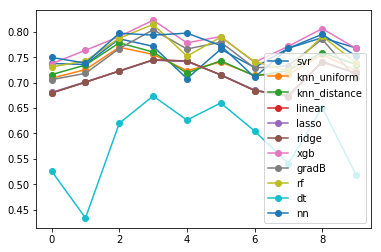

In [74]:
plot(r2_scores)

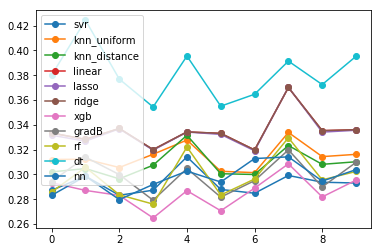

In [75]:
plot(rmse_scores)

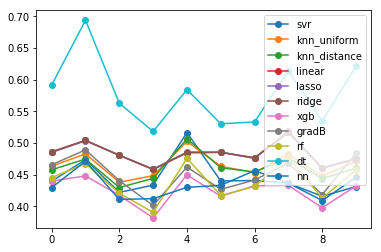

In [76]:
plot(mae_scores)

In [77]:
r2_scores_svr, rmse_scores_svr, mae_scores_svr = score('svr', X_test, y_test)

svr algorithm: P-value of KS test: 0.452882 and r2 score: 0.342488
svr algorithm: P-value of KS test: 0.418847 and r2 score: 0.341132
svr algorithm: P-value of KS test: 0.488324 and r2 score: 0.342785
svr algorithm: P-value of KS test: 0.488324 and r2 score: 0.339499
svr algorithm: P-value of KS test: 0.452882 and r2 score: 0.340546
svr algorithm: P-value of KS test: 0.418847 and r2 score: 0.341758
svr algorithm: P-value of KS test: 0.452882 and r2 score: 0.340967
svr algorithm: P-value of KS test: 0.488324 and r2 score: 0.340421
svr algorithm: P-value of KS test: 0.452882 and r2 score: 0.339610
svr algorithm: P-value of KS test: 0.326178 and r2 score: 0.334982
R2 score is 0.340419


In [78]:
r2_scores_knn_uniform, rmse_scores_knn_uniform, mae_scores_knn_uniform = score('knn_uniform', X_test, y_test)


knn_uniform algorithm: P-value of KS test: 0.077054 and r2 score: 0.395958
knn_uniform algorithm: P-value of KS test: 0.047151 and r2 score: 0.388387
knn_uniform algorithm: P-value of KS test: 0.053484 and r2 score: 0.397195
knn_uniform algorithm: P-value of KS test: 0.097232 and r2 score: 0.401063
knn_uniform algorithm: P-value of KS test: 0.060537 and r2 score: 0.389929
knn_uniform algorithm: P-value of KS test: 0.053484 and r2 score: 0.395979
knn_uniform algorithm: P-value of KS test: 0.036408 and r2 score: 0.399430
knn_uniform algorithm: P-value of KS test: 0.047151 and r2 score: 0.394382
knn_uniform algorithm: P-value of KS test: 0.027871 and r2 score: 0.370285
knn_uniform algorithm: P-value of KS test: 0.031889 and r2 score: 0.392706
R2 score is 0.392531


In [79]:
r2_scores_knn_distance, rmse_scores_knn_distance, mae_scores_knn_distance = score('knn_distance', X_test, y_test)


knn_distance algorithm: P-value of KS test: 0.135596 and r2 score: 0.381023
knn_distance algorithm: P-value of KS test: 0.150833 and r2 score: 0.385109
knn_distance algorithm: P-value of KS test: 0.068372 and r2 score: 0.392815
knn_distance algorithm: P-value of KS test: 0.167414 and r2 score: 0.391842
knn_distance algorithm: P-value of KS test: 0.204878 and r2 score: 0.387721
knn_distance algorithm: P-value of KS test: 0.167414 and r2 score: 0.381352
knn_distance algorithm: P-value of KS test: 0.086651 and r2 score: 0.362631
knn_distance algorithm: P-value of KS test: 0.150833 and r2 score: 0.386747
knn_distance algorithm: P-value of KS test: 0.150833 and r2 score: 0.393502
knn_distance algorithm: P-value of KS test: 0.097232 and r2 score: 0.393272
R2 score is 0.385601


In [80]:
r2_scores_linear, rmse_scores_linear, mae_scores_linear = score('linear', X_test, y_test)


linear algorithm: P-value of KS test: 0.108868 and r2 score: 0.724730
linear algorithm: P-value of KS test: 0.121632 and r2 score: 0.727579
linear algorithm: P-value of KS test: 0.068372 and r2 score: 0.730328
linear algorithm: P-value of KS test: 0.150833 and r2 score: 0.731717
linear algorithm: P-value of KS test: 0.121632 and r2 score: 0.743861
linear algorithm: P-value of KS test: 0.086651 and r2 score: 0.732129
linear algorithm: P-value of KS test: 0.108868 and r2 score: 0.730175
linear algorithm: P-value of KS test: 0.086651 and r2 score: 0.738308
linear algorithm: P-value of KS test: 0.121632 and r2 score: 0.742370
linear algorithm: P-value of KS test: 0.077054 and r2 score: 0.739194
R2 score is 0.734039


In [81]:
r2_scores_lasso, rmse_scores_lasso, mae_scores_lasso = score('lasso', X_test, y_test)


lasso algorithm: P-value of KS test: 0.086651 and r2 score: 0.738331
lasso algorithm: P-value of KS test: 0.086651 and r2 score: 0.742371
lasso algorithm: P-value of KS test: 0.121632 and r2 score: 0.731792
lasso algorithm: P-value of KS test: 0.053484 and r2 score: 0.730168
lasso algorithm: P-value of KS test: 0.077054 and r2 score: 0.739171
lasso algorithm: P-value of KS test: 0.097232 and r2 score: 0.730240
lasso algorithm: P-value of KS test: 0.121632 and r2 score: 0.724834
lasso algorithm: P-value of KS test: 0.077054 and r2 score: 0.732059
lasso algorithm: P-value of KS test: 0.097232 and r2 score: 0.727541
lasso algorithm: P-value of KS test: 0.121632 and r2 score: 0.743874
R2 score is 0.734038


In [82]:
r2_scores_ridge, rmse_scores_ridge, mae_scores_ridge = score('ridge', X_test, y_test)


ridge algorithm: P-value of KS test: 0.086651 and r2 score: 0.738309
ridge algorithm: P-value of KS test: 0.121632 and r2 score: 0.727580
ridge algorithm: P-value of KS test: 0.150833 and r2 score: 0.731718
ridge algorithm: P-value of KS test: 0.108868 and r2 score: 0.730176
ridge algorithm: P-value of KS test: 0.108868 and r2 score: 0.724732
ridge algorithm: P-value of KS test: 0.086651 and r2 score: 0.732131
ridge algorithm: P-value of KS test: 0.121632 and r2 score: 0.742371
ridge algorithm: P-value of KS test: 0.077054 and r2 score: 0.739195
ridge algorithm: P-value of KS test: 0.068372 and r2 score: 0.730329
ridge algorithm: P-value of KS test: 0.121632 and r2 score: 0.743862
R2 score is 0.734040


In [83]:
r2_scores_xgb, rmse_scores_xgb, mae_scores_xgb = score('xgb', X_test, y_test)


xgb algorithm: P-value of KS test: 0.150833 and r2 score: 0.467075
xgb algorithm: P-value of KS test: 0.077054 and r2 score: 0.479278
xgb algorithm: P-value of KS test: 0.097232 and r2 score: 0.487981
xgb algorithm: P-value of KS test: 0.047151 and r2 score: 0.464646
xgb algorithm: P-value of KS test: 0.086651 and r2 score: 0.432191
xgb algorithm: P-value of KS test: 0.167414 and r2 score: 0.463301
xgb algorithm: P-value of KS test: 0.060537 and r2 score: 0.463251
xgb algorithm: P-value of KS test: 0.086651 and r2 score: 0.473951
xgb algorithm: P-value of KS test: 0.108868 and r2 score: 0.468757
xgb algorithm: P-value of KS test: 0.150833 and r2 score: 0.478263
R2 score is 0.467869


In [84]:
r2_scores_gradB, rmse_scores_gradB, mae_scores_gradB = score('gradB', X_test, y_test)


gradB algorithm: P-value of KS test: 0.167414 and r2 score: 0.369276
gradB algorithm: P-value of KS test: 0.204878 and r2 score: 0.396951
gradB algorithm: P-value of KS test: 0.121632 and r2 score: 0.432885
gradB algorithm: P-value of KS test: 0.204878 and r2 score: 0.394667
gradB algorithm: P-value of KS test: 0.204878 and r2 score: 0.424058
gradB algorithm: P-value of KS test: 0.355430 and r2 score: 0.456261
gradB algorithm: P-value of KS test: 0.272712 and r2 score: 0.441813
gradB algorithm: P-value of KS test: 0.298605 and r2 score: 0.397713
gradB algorithm: P-value of KS test: 0.121632 and r2 score: 0.439412
gradB algorithm: P-value of KS test: 0.298605 and r2 score: 0.446632
R2 score is 0.419967


In [85]:
r2_scores_rf, rmse_scores_rf, mae_scores_rf = score('rf', X_test, y_test)


rf algorithm: P-value of KS test: 0.086651 and r2 score: 0.434707
rf algorithm: P-value of KS test: 0.097232 and r2 score: 0.441665
rf algorithm: P-value of KS test: 0.185407 and r2 score: 0.432921
rf algorithm: P-value of KS test: 0.108868 and r2 score: 0.433667
rf algorithm: P-value of KS test: 0.150833 and r2 score: 0.394172
rf algorithm: P-value of KS test: 0.053484 and r2 score: 0.428531
rf algorithm: P-value of KS test: 0.121632 and r2 score: 0.433446
rf algorithm: P-value of KS test: 0.135596 and r2 score: 0.423497
rf algorithm: P-value of KS test: 0.077054 and r2 score: 0.421393
rf algorithm: P-value of KS test: 0.185407 and r2 score: 0.438263
R2 score is 0.428226


In [86]:
r2_scores_dt, rmse_scores_dt, mae_scores_dt = score('dt', X_test, y_test)


dt algorithm: P-value of KS test: 0.756226 and r2 score: 0.375979
dt algorithm: P-value of KS test: 0.756226 and r2 score: 0.411782
dt algorithm: P-value of KS test: 0.640279 and r2 score: 0.359706
dt algorithm: P-value of KS test: 0.718203 and r2 score: 0.386480
dt algorithm: P-value of KS test: 0.015915 and r2 score: 0.274056
dt algorithm: P-value of KS test: 0.640279 and r2 score: 0.328172
dt algorithm: P-value of KS test: 0.827824 and r2 score: 0.277472
dt algorithm: P-value of KS test: 0.679396 and r2 score: 0.362980
dt algorithm: P-value of KS test: 0.889875 and r2 score: 0.378910
dt algorithm: P-value of KS test: 0.488324 and r2 score: 0.302188
R2 score is 0.345772


In [87]:
r2_scores_nn, rmse_scores_nn, mae_scores_nn = score('nn', X_test, y_test)

nn algorithm: P-value of KS test: 0.108868 and r2 score: 0.776827
nn algorithm: P-value of KS test: 0.326178 and r2 score: 0.720907
nn algorithm: P-value of KS test: 0.086651 and r2 score: 0.692526
nn algorithm: P-value of KS test: 0.248482 and r2 score: 0.756051
nn algorithm: P-value of KS test: 0.326178 and r2 score: 0.717729
nn algorithm: P-value of KS test: 0.013760 and r2 score: 0.707463
nn algorithm: P-value of KS test: 0.355430 and r2 score: 0.743238
nn algorithm: P-value of KS test: 0.272712 and r2 score: 0.692100
nn algorithm: P-value of KS test: 0.086651 and r2 score: 0.677332
nn algorithm: P-value of KS test: 0.150833 and r2 score: 0.724969
R2 score is 0.720914


In [0]:
r2_scores = {'svr' : r2_scores_svr, 'knn_uniform' : r2_scores_knn_uniform, 'knn_distance' : r2_scores_knn_distance,\
    'linear' : r2_scores_linear, 'lasso' : r2_scores_lasso, 'ridge' : r2_scores_ridge, 'xgb' : r2_scores_xgb,\
        'gradB' : r2_scores_gradB, 'rf' : r2_scores_rf, 'dt' : r2_scores_dt, 'nn' : r2_scores_nn}

rmse_scores = {'svr' : rmse_scores_svr, 'knn_uniform' : rmse_scores_knn_uniform, 'knn_distance' : rmse_scores_knn_distance,\
    'linear' : rmse_scores_linear, 'lasso' : rmse_scores_lasso, 'ridge' : rmse_scores_ridge, 'xgb' : rmse_scores_xgb,\
        'gradB' : rmse_scores_gradB, 'rf' : rmse_scores_rf, 'dt' : rmse_scores_dt, 'nn' : rmse_scores_nn}

mae_scores = {'svr' : mae_scores_svr, 'knn_uniform' : mae_scores_knn_uniform, 'knn_distance' : mae_scores_knn_distance,\
    'linear' : mae_scores_linear, 'lasso' : mae_scores_lasso, 'ridge' : mae_scores_ridge, 'xgb' : mae_scores_xgb,\
        'gradB' : mae_scores_gradB, 'rf' : mae_scores_rf, 'dt' : mae_scores_dt, 'nn' : mae_scores_nn}

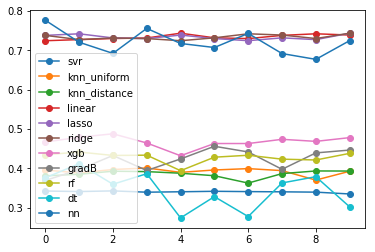

In [89]:
plot(r2_scores)

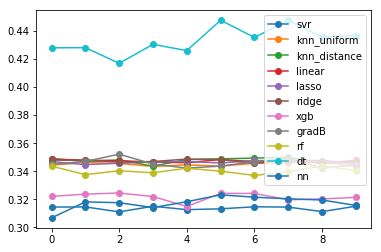

In [90]:
plot(rmse_scores)

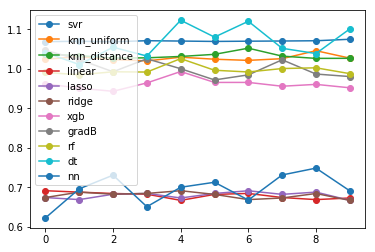

In [91]:
plot(mae_scores)